# Setup

In [1]:
import torch
from torchvision import datasets, transforms 
from sklearn.metrics import classification_report

In [2]:
%run setup.ipynb 

# Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.

## Augmentation round 1

First, just gonna mess up the pictures a little - no sciency arguments for it other than intuitively trying to capture that the feeder images are more grainy and the birds are not always perfectly posed (hence the crop).

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation1 = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
# looking at the augmentations..
inputs, classes = next(iter(dataloader_train_aug1))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[x] for x in classes])

Load in a fresh ResNet50 that's prepped for transfer learning

In [ ]:
# load "clean" resnet50
untrained_model_aug1 = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model_aug1) # FIXME does this change?

### Training
First with the frozen layers, then unfreeze for finetuning

In [ ]:
freezetrained_model_aug1, freeze_aug1_info = train_model(model=untrained_model_aug1, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug1)

In [ ]:
unfreeze_layers(freezetrained_model_aug1)
model_aug1, model_aug1_info = train_model(model=freezetrained_model_aug1, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug1)

In [ ]:
torch.save({"aug1": model_aug1.state_dict(), "aug1_info": model_aug1_info, "freeze_aug1_info": freeze_aug1_info},"aug1Model_40.tar")

### Round 1 results

In [ ]:
visualize_model(model_aug1, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug1_info["train_loss"], model_aug1_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug1_info["train_acc"], model_aug1_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


In [ ]:
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug1, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))


## Augmentation Round 2

Add blur and colorjitter

In [ ]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation2 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1), # Added
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug2 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation2)
dataloader_train_aug2 = torch.utils.data.DataLoader(dataset_train_aug2, batch_size=8, shuffle=True, num_workers=4)

Load in a fresh ResNet50 that's prepped for transfer learning

In [ ]:
# load "clean" resnet50
untrained_model_aug2 = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model_aug2) 


### Training
First with the frozen layers, then unfreeze for finetuning

In [ ]:
freezetrained_model_aug2, freeze_aug2_info = train_model(model=untrained_model_aug2, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug2) 

In [ ]:
unfreeze_layers(freezetrained_model_aug2)
model_aug2, model_aug2_info = train_model(model=freezetrained_model_aug2, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug2)

In [ ]:
torch.save({"aug2": model_aug2.state_dict(), "aug2_info": model_aug2_info, "freeze_aug1_info": freeze_aug2_info},"aug2Model_40.tar")

### Round 2 Results

In [ ]:
visualize_model(model_aug2, dataloader_tiny_val, class_labels, device)

In [ ]:
plot_accuracies(model_aug2_info["train_loss"], model_aug2_info["val_loss"], ["Train", "Val"])

In [ ]:
plot_accuracies(model_aug2_info["train_acc"], model_aug2_info["val_acc"], ["Train", "Val"])

In [ ]:
truel, predl = makeAll(dataloader_test, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

### On feeder

In [ ]:
truel, predl = makeAll(dataloader_feeder, model_aug2, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

## Augmentation round 3

Try without jitter

In [3]:
# Defining the transforms including augmentations (and also the basic ToTensor and normalisation)
preprocess_with_augmentation3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)), # Added
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224,scale=(0.3,1)), # lowerbound the scale at 30 % of og img to not get too small portions

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and loaders with augmentations added 
dataset_train_aug3 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation3)
dataloader_train_aug3 = torch.utils.data.DataLoader(dataset_train_aug3, batch_size=8, shuffle=True, num_workers=4)

Load in a fresh ResNet50 that's prepped for transfer learning

In [4]:
# load "clean" resnet50
untrained_model_aug3 = load_and_prep_resnet50()
optimizer = get_optimizer(untrained_model_aug3) 

### Training
First with the frozen layers, then unfreeze for finetuning

In [5]:
freezetrained_model_aug3, freeze_aug3_info = train_model(model=untrained_model_aug3, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug3) 

Epoch 1/40
----------
Train Loss: 1.8342 Acc: 0.3545
Val Loss: 1.7958 Acc: 0.4038
Epoch time 1m 9s
----------

Epoch 2/40
----------
Train Loss: 1.5912 Acc: 0.5856
Val Loss: 1.6657 Acc: 0.5769
Epoch time 1m 9s
----------

Epoch 3/40
----------
Train Loss: 1.3921 Acc: 0.7078
Val Loss: 1.5543 Acc: 0.5577
Epoch time 1m 9s
----------

Epoch 4/40
----------
Train Loss: 1.2678 Acc: 0.7030
Val Loss: 1.4714 Acc: 0.6250
Epoch time 1m 9s
----------

Epoch 5/40
----------
Train Loss: 1.1674 Acc: 0.7066
Val Loss: 1.4275 Acc: 0.5769
Epoch time 1m 9s
----------

Epoch 6/40
----------
Train Loss: 1.1176 Acc: 0.7293
Val Loss: 1.3428 Acc: 0.6346
Epoch time 1m 9s
----------

Epoch 7/40
----------
Train Loss: 1.0538 Acc: 0.7269
Val Loss: 1.3379 Acc: 0.6346
Epoch time 1m 9s
----------

Epoch 8/40
----------
Train Loss: 0.9668 Acc: 0.7677
Val Loss: 1.2927 Acc: 0.6635
Epoch time 1m 9s
----------

Epoch 9/40
----------
Train Loss: 0.9559 Acc: 0.7509
Val Loss: 1.2424 Acc: 0.6923
Epoch time 1m 9s
----------

E

In [6]:
unfreeze_layers(freezetrained_model_aug3)
model_aug3, model_aug3_info = train_model(model=freezetrained_model_aug3, optimizer=optimizer, num_epoch=40, train=dataloader_train_aug3)

Epoch 1/40
----------
Train Loss: 0.5178 Acc: 0.8491
Val Loss: 0.3946 Acc: 0.8942
Epoch time 1m 51s
----------

Epoch 2/40
----------
Train Loss: 0.3469 Acc: 0.8683
Val Loss: 0.3825 Acc: 0.8942
Epoch time 1m 50s
----------

Epoch 3/40
----------
Train Loss: 0.2754 Acc: 0.9090
Val Loss: 0.2858 Acc: 0.9327
Epoch time 1m 50s
----------

Epoch 4/40
----------
Train Loss: 0.2089 Acc: 0.9305
Val Loss: 0.3347 Acc: 0.9135
Epoch time 1m 50s
----------

Epoch 5/40
----------
Train Loss: 0.2066 Acc: 0.9329
Val Loss: 0.4443 Acc: 0.8846
Epoch time 1m 50s
----------

Epoch 6/40
----------
Train Loss: 0.1654 Acc: 0.9473
Val Loss: 0.2398 Acc: 0.9231
Epoch time 1m 50s
----------

Epoch 7/40
----------
Train Loss: 0.1413 Acc: 0.9617
Val Loss: 0.2392 Acc: 0.9423
Epoch time 1m 51s
----------

Epoch 8/40
----------
Train Loss: 0.1282 Acc: 0.9629
Val Loss: 0.3959 Acc: 0.8942
Epoch time 1m 53s
----------

Epoch 9/40
----------
Train Loss: 0.1142 Acc: 0.9653
Val Loss: 0.2207 Acc: 0.9423
Epoch time 1m 51s
----

In [7]:
torch.save({"aug3": model_aug3.state_dict(), "aug3_info": model_aug3_info, "freeze_aug3_info": freeze_aug3_info},"aug3Model_40.tar")

### Round 3 Results

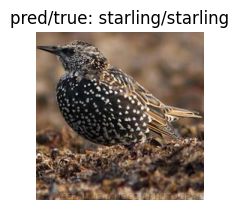

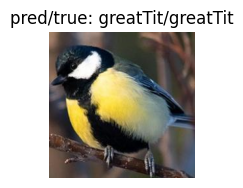

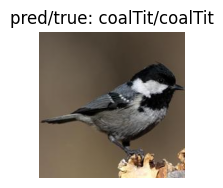

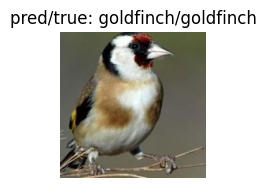

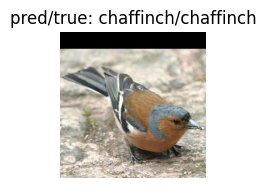

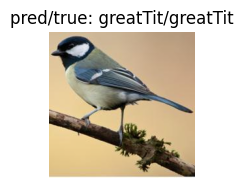

In [8]:
visualize_model(model_aug3, dataloader_tiny_val, class_labels, device)

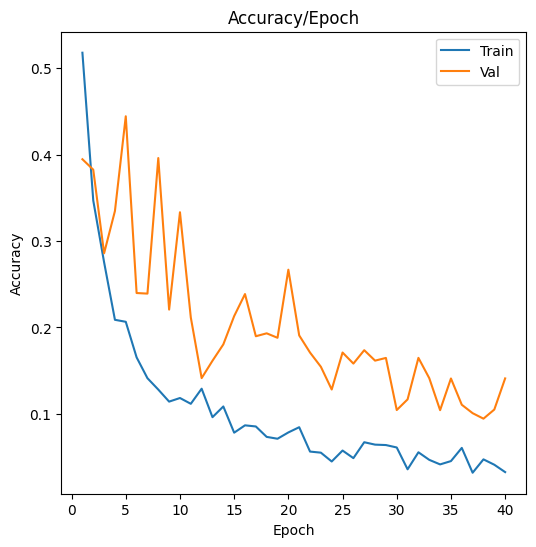

In [9]:
plot_accuracies(model_aug3_info["train_loss"], model_aug3_info["val_loss"], ["Train", "Val"])

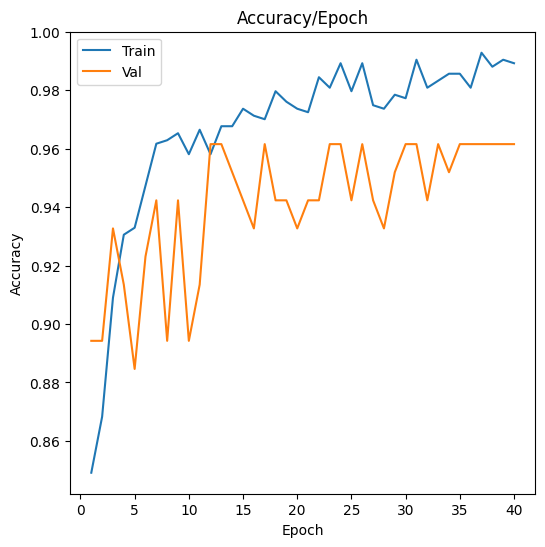

In [10]:
plot_accuracies(model_aug3_info["train_acc"], model_aug3_info["val_acc"], ["Train", "Val"])

[[15  0  0  0  0  0  0]
 [ 0 14  0  0  0  1  0]
 [ 0  0 14  0  0  0  1]
 [ 0  1  0 14  0  0  0]
 [ 0  0  3  0 12  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]
Accuracy 94.28571428571428


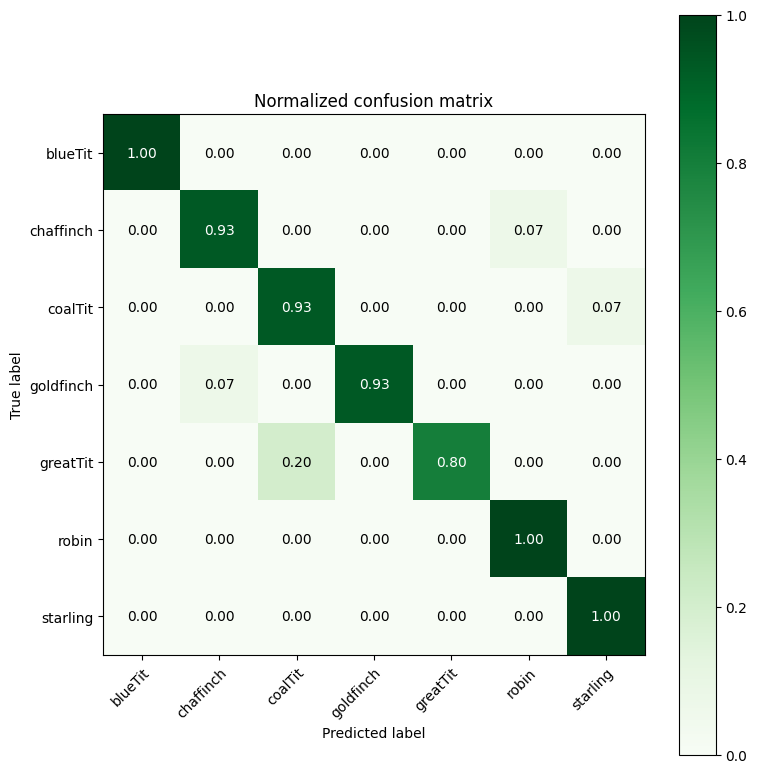

In [11]:
truel, predl = makeAll(dataloader_test, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [12]:
class_labels = ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
print(classification_report(truel, predl, target_names=class_labels))

              precision    recall  f1-score   support

     blueTit       1.00      1.00      1.00        15
   chaffinch       0.93      0.93      0.93        15
     coalTit       0.82      0.93      0.87        15
   goldfinch       1.00      0.93      0.97        15
    greatTit       1.00      0.80      0.89        15
       robin       0.94      1.00      0.97        15
    starling       0.94      1.00      0.97        15

    accuracy                           0.94       105
   macro avg       0.95      0.94      0.94       105
weighted avg       0.95      0.94      0.94       105



### On Feeder

[[ 934    1  134    7  130   26  846]
 [  59 1766  264   52    4  278 1129]
 [   1    0  986    0    0    5  854]
 [   2   16   39 1846    1   16   80]
 [ 182    0  488    9  747    1  606]
 [  22  120    0   39    1  537  709]
 [   0    0    0    0    0    1 2141]]
Accuracy 59.40049074872339


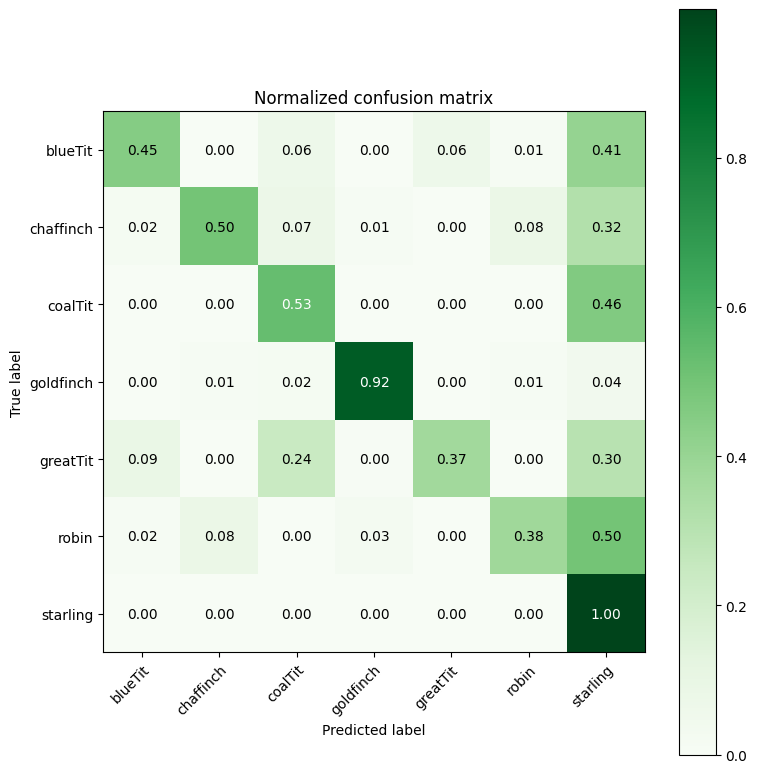

In [13]:
truel, predl = makeAll(dataloader_feeder, model_aug3, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))